# Hidden markov model (HMM)

The goal is to use to find looped and unlooped states in the data from single particle tracking of dual colors.

We will use Gaussian model for emission. 
Given all the data we fit the all the parameters (gaussian parameters, transition probability between looped/unlooped).

Once we have the model, we use the model to predict the states on the different datasets.

As control, we could use the TetO dual color control line (looped state) and dual color in dCTCF and +auxin (unlooped state)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

### Dual color imaging at 10s

To estimate the transition probability, we should have data without gaps. However we have gaps from time to time . To cope with this, we filled gaps using the distance of the first previous frame with no missing value. We allow maximum 10\% of tracks to be with missing values

In [3]:
fraction_nan_max = 0.1 # maximum fraction of gaps allowed 
reproducible = True
if reproducible:
    np.random.seed(43)

From the experimental data we got an error estimate of 170nm on distance. We will set the minimum diagonal of covariance matrix (error on the estimates) to be equal to 100nm (0.1).

### Model training

Average datapoints across trajectories 165.45065789473685
number of data points used in the model (50297, 1)
Gaussian means: [[0.21306088]
 [0.51567288]] 
 ------
Gaussian std: [0.08941515 0.21566563] 
 ------
Transition rates: [[0.98027173 0.01972827]
 [0.04193545 0.95806455]] 
 ------
logProg = 31872.106716037917 
 ------
Starting probability = [0.5 0.5] 
 ------


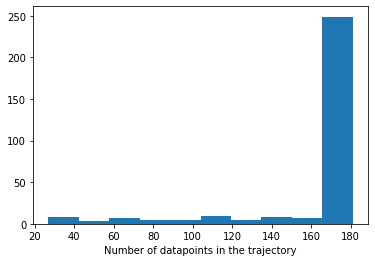

In [4]:
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
name = "two_colors_distance_10s"
dataset = f"{basedir}/211126_{name}.csv.zip"

data = pd.read_csv(dataset)

original = pd.DataFrame()
length = []
for _, sub in data.groupby("uniqueid"):
    sub, c = fill_gaps(sub, "frame")
    if c / len(sub) < fraction_nan_max:
        original = pd.concat([original, sub])
        length.append(len(sub))

plt.hist(length)
plt.xlabel("Number of datapoints in the trajectory")
print(f"Average datapoints across trajectories {np.mean(length)}")
data = original.copy()


traj = data["distance"].values

# hmm needs as input (obs, nfeatures)
traj2d = np.reshape((traj), (-1, 1))
print(f"number of data points used in the model {traj2d.shape}")

# initiate model

model = hmm.GaussianHMM(
    n_components=2,
    covariance_type="full",
    min_covar=0.1,
    n_iter=10000,
    params="mtc",
    init_params="mtc",
)

# instead of fitting
model.startprob_ = [0.5, 0.5]
model.fit(traj2d)

means = model.means_
sigmas = np.sqrt(model.covars_.squeeze())
w = np.array(model.transmat_)
logProb = model.score(traj2d)
print(f"Gaussian means: {means} \n ------")
print(f"Gaussian std: {sigmas} \n ------")
print(f"Transition rates: {w} \n ------")
print(f"logProg = {logProb} \n ------")
print(f"Starting probability = {model.startprob_} \n ------")

with open(f"{basedir}/hmmmodel_{name}.obj", "wb") as file_model:
    pickle.dump(model, file_model)